<font size="6">**Team 01 - Datathon - Machine Learning**</font>

# Objective : 
This notebook goes through in detail the building and evaluation of the prediction models for VitalDB dataset

# Executive Summary 

1. The best performing model is the Extreme Gradient Boosting GBM model with auc of 0.9134.
2. The important variables that contributed towards the above prediction accuracy are:
    - optype_7 - Transplanation 
    - b4_lac - Lactive
    - b4_be - Base Excess

# Machine Learnig Classification Models

## Import libararies

In [2]:
#import libararies
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected = True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly import tools

from sklearn.impute import SimpleImputer


import model_func
#to make sure kernel restart is not needed after making changes in .py
import importlib
importlib.reload(model_func)


from xgboost import XGBClassifier


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_curve, roc_auc_score, auc


from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from datetime import datetime

import random
import warnings
warnings.filterwarnings("ignore")
from time import time
from sklearn.metrics import f1_score, accuracy_score

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import shap


In [3]:
df =  pd.read_excel('01_data_compiled_selected_patients_4221.xlsx')
print(df.shape)

(4221, 84)


In [4]:
#display all columns
pd.set_option("display.max_columns",None)
df.head()

caseid  complications  icu_days  death_inhosp  pre_post_cr   age  sex  \
0       1              0         0             0     0.878049  77.0    0   
1       2              0         0             0     0.953488  54.0    0   
2       7              1         3             0          NaN  52.0    1   
3       9              0         0             0          NaN  32.0    1   
4      10              0         1             0     0.725000  72.0    0   

   height  weight   bmi    asa            optype     approach  emop ane_type  \
0   160.2   67.50  26.3  cat02        Colorectal         Open     0  General   
1   167.3   54.80  19.6  cat02           Stomach         Open     0  General   
2   167.7   62.30  22.2  cat02   Major resection  Videoscopic     0  General   
3   157.9   50.90  20.4  cat01  Biliary/Pancreas  Videoscopic     0  General   
4   162.5   62.75  23.8  cat03           Stomach  Videoscopic     0  General   

   preop_htn  preop_dm preop_pft  optype_00  optype_01  optype_02  optype_03  \
0          1         0    Normal          1          0          0          0   
1          0         0    Normal          0          0          1          0   
2          0         0    Normal          0          0          0          1   
3          0         0    Normal          0          1          0          0   
4          1         0    Normal          0          0          1          0   

   optype_04  optype_05  optype_06  optype_07  optype_08  optype_09  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   optype_10  approach_00  approach_01  approach_02  ane_type_00  ane_type_01  \
0          0            1            0            0            1            0   
1          0            1            0            0            1            0   
2          0            0            1            0            1            0   
3          0            0            1            0            1            0   
4          0            0            1            0            1            0   

   ane_type_02  preop_pft_00  preop_pft_01  preop_pft_02  preop_pft_03  \
0            0             1             0             0             0   
1            0             1             0             0             0   
2            0             1             0             0             0   
3            0             1             0             0             0   
4            0             1             0             0             0   

   preop_pft_04  preop_pft_05  preop_pft_06  preop_pft_07  preop_pft_08  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   asa_00  asa_01  asa_02  asa_03  asa_04  asa_05  b4_alb  b4_alt  b4_ammo  \
0       1       0       0       0       0       0     3.4    20.0      NaN   
1       1       0       0       0       0       0     3.1    19.0      NaN   
2       1       0       0       0       0       0     4.4    16.0      NaN   
3       0       1       0       0       0       0     4.4     8.0      NaN   
4       0       0       1       0       0       0     3.2    54.0      NaN   

   b4_aptt  b4_ast  b4_be  b4_bun  b4_ccr  b4_cl  b4_cr  b4_crp  b4_esr  \
0     28.0    20.0    NaN    15.0     NaN  100.0   0.88   22.41     NaN   
1     28.6    29.0    NaN    12.0     NaN  115.0   1.02   16.18     NaN   
2     26.4    20.0    0.8    18.0     NaN  106.0   0.84    0.09     NaN   
3    

## Feature Engineering 

In [5]:
df['complications'].value_counts()

complications
0    3957
1     264
Name: count, dtype: int64

1. **height &  weight** removed because of BMI 
2. **death_inhosp, pre_post_cr & icu_days** removed to avoid target leakage
3. **optype** - One-Hot encoding (OHE) 
4. **approach**-OHE 
5. **ane_type**- OHE 
6. **preop_pft** - OHE
7. **asa** - OHE 

In [6]:
#dropping not required and categorical features
df= df.drop(['death_inhosp','caseid','icu_days','height','weight','pre_post_cr','approach',\
             'ane_type','asa', 'optype','preop_pft'],axis= 1)

In [7]:
df.head()

complications   age  sex   bmi  emop  preop_htn  preop_dm  optype_00  \
0              0  77.0    0  26.3     0          1         0          1   
1              0  54.0    0  19.6     0          0         0          0   
2              1  52.0    1  22.2     0          0         0          0   
3              0  32.0    1  20.4     0          0         0          0   
4              0  72.0    0  23.8     0          1         0          0   

   optype_01  optype_02  optype_03  optype_04  optype_05  optype_06  \
0          0          0          0          0          0          0   
1          0          1          0          0          0          0   
2          0          0          1          0          0          0   
3          1          0          0          0          0          0   
4          0          1          0          0          0          0   

   optype_07  optype_08  optype_09  optype_10  approach_00  approach_01  \
0          0          0          0          0            1            0   
1          0          0          0          0            1            0   
2          0          0          0          0            0            1   
3          0          0          0          0            0            1   
4          0          0          0          0            0            1   

   approach_02  ane_type_00  ane_type_01  ane_type_02  preop_pft_00  \
0            0            1            0            0             1   
1            0            1            0            0             1   
2            0            1            0            0             1   
3            0            1            0            0             1   
4            0            1            0            0             1   

   preop_pft_01  preop_pft_02  preop_pft_03  preop_pft_04  preop_pft_05  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   preop_pft_06  preop_pft_07  preop_pft_08  asa_00  asa_01  asa_02  asa_03  \
0             0             0             0       1       0       0       0   
1             0             0             0       1       0       0       0   
2             0             0             0       1       0       0       0   
3             0             0             0       0       1       0       0   
4             0             0             0       0       0       1       0   

   asa_04  asa_05  b4_alb  b4_alt  b4_ammo  b4_aptt  b4_ast  b4_be  b4_bun  \
0       0       0     3.4    20.0      NaN     28.0    20.0    NaN    15.0   
1       0       0     3.1    19.0      NaN     28.6    29.0    NaN    12.0   
2       0       0     4.4    16.0      NaN     26.4    20.0    0.8    18.0   
3       0       0     4.4     8.0      NaN      NaN    13.0    NaN     NaN   
4       0       0     3.2    54.0      NaN     27.3    57.0    NaN    18.0   

   b4_ccr  b4_cl  b4_cr  b4_crp  b4_esr  b4_fib  b4_gfr  b4_gluc  b4_hb  \
0     NaN  100.0   0.88   22.41     NaN   254.0    83.8    198.0   13.4   
1     NaN  115.0   1.02   16.18     NaN   290.0    75.9    118.0   10.2   
2     NaN  106.0   0.84    0.09     NaN   271.0    70.9     94.0   11.8   
3     NaN    NaN    NaN     NaN     NaN     NaN     NaN      NaN   12.8   
4     NaN  104.0   1.15    0.10     NaN   336.0    62.5    315.0   13.6   

   b4_hco3  b4_hct  b4_ica  b4_k  b4_lac  b4_na  b4_p  b4_pco2  b4_ph  b4_plt  \
0      NaN    38.9     NaN   3.1     NaN  138.0   NaN      NaN    NaN   146.0   
1      NaN    32.5     NaN   4.7     NaN  143.0   NaN      NaN    NaN   251.0   
2     25.4    35.1    1.17   4.4     1.2  139.0   NaN     47.0   7.34   229.0   
3      NaN    39.5     NaN   NaN     NaN    NaN   NaN      NaN    NaN   133.0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   complications  4221 non-null   int64  
 1   age            4221 non-null   float64
 2   sex            4221 non-null   int64  
 3   bmi            4221 non-null   float64
 4   emop           4221 non-null   int64  
 5   preop_htn      4221 non-null   int64  
 6   preop_dm       4221 non-null   int64  
 7   optype_00      4221 non-null   int64  
 8   optype_01      4221 non-null   int64  
 9   optype_02      4221 non-null   int64  
 10  optype_03      4221 non-null   int64  
 11  optype_04      4221 non-null   int64  
 12  optype_05      4221 non-null   int64  
 13  optype_06      4221 non-null   int64  
 14  optype_07      4221 non-null   int64  
 15  optype_08      4221 non-null   int64  
 16  optype_09      4221 non-null   int64  
 17  optype_10      4221 non-null   int64  
 18  approach

In [9]:
# Check for missing values in each column and sum them up
missing_values = df.isnull().sum()

# Filter columns with missing values (count > 0)
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values
print("Columns with Missing Values:")
print(columns_with_missing_values)


Columns with Missing Values:
b4_alb       266
b4_alt       265
b4_ammo     4161
b4_aptt      798
b4_ast       265
b4_be       3552
b4_bun       330
b4_ccr      4088
b4_cl        264
b4_cr        330
b4_crp       718
b4_esr      3800
b4_fib       913
b4_gfr       340
b4_gluc      652
b4_hb        292
b4_hco3     3336
b4_hct       289
b4_ica      2974
b4_k         260
b4_lac      3338
b4_na        260
b4_p        2158
b4_pco2     3336
b4_ph       3336
b4_plt       294
b4_po2      3336
b4_pt%       795
b4_ptinr     795
b4_ptsec     795
b4_sao2     3336
b4_tbil      266
b4_tprot     266
b4_wbc       292
dtype: int64


## Correlation 

In [10]:
data_corr = df.select_dtypes(include=[np.number])
#Generate correlation matrix
corrMatrix = data_corr.corr()
corrMatrix.head(20)

complications       age       sex       bmi  emop  preop_htn  \
complications       1.000000 -0.008909 -0.074019 -0.064579   NaN   0.011674   
age                -0.008909  1.000000 -0.094336  0.057388   NaN   0.351691   
sex                -0.074019 -0.094336  1.000000 -0.010117   NaN  -0.069687   
bmi                -0.064579  0.057388 -0.010117  1.000000   NaN   0.173192   
emop                     NaN       NaN       NaN       NaN   NaN        NaN   
preop_htn           0.011674  0.351691 -0.069687  0.173192   NaN   1.000000   
preop_dm            0.019478  0.167679 -0.054123  0.053262   NaN   0.148003   
optype_00          -0.077737  0.147385 -0.051815 -0.015822   NaN   0.054002   
optype_01          -0.051351  0.009352  0.044785  0.058730   NaN   0.013575   
optype_02          -0.049691  0.060796 -0.047986 -0.064460   NaN   0.005444   
optype_03           0.013071  0.077954 -0.017575  0.046188   NaN   0.033480   
optype_04           0.050824 -0.074684 -0.033683 -0.090875   NaN  -0.065367   
optype_05          -0.053772  0.016481  0.025327  0.016686   NaN  -0.015935   
optype_06          -0.047760 -0.084343  0.220815  0.044581   NaN  -0.046769   
optype_07           0.340179 -0.233618 -0.008011 -0.064793   NaN  -0.018890   
optype_08          -0.053879 -0.138941  0.080503  0.096490   NaN  -0.061722   
optype_09          -0.016550  0.032380 -0.101409  0.021904   NaN   0.015168   
optype_10           0.031644  0.014413 -0.035286 -0.016518   NaN   0.052810   
approach_00         0.082909 -0.032829  0.006697 -0.069514   NaN   0.006331   
approach_01        -0.074514  0.055303  0.010856  0.039060   NaN   0.000672   

               preop_dm  optype_00  optype_01  optype_02  optype_03  \
complications  0.019478  -0.077737  -0.051351  -0.049691   0.013071   
age            0.167679   0.147385   0.009352   0.060796   0.077954   
sex           -0.054123  -0.051815   0.044785  -0.047986  -0.017575   
bmi            0.053262  -0.015822   0.058730  -0.064460   0.046188   
emop                NaN        NaN        NaN        NaN        NaN   
preop_htn      0.148003   0.054002   0.013575   0.005444   0.033480   
preop_dm       1.000000   0.007365   0.044605   0.023271   0.026733   
optype_00      0.007365   1.000000  -0.210191  -0.188207  -0.193184   
optype_01      0.044605  -0.210191   1.000000  -0.129964  -0.133400   
optype_02      0.023271  -0.188207  -0.129964   1.000000  -0.119448   
optype_03      0.026733  -0.193184  -0.133400  -0.119448   1.000000   
optype_04     -0.024538  -0.187011  -0.129138  -0.115632  -0.118689   
optype_05     -0.005340  -0.189637  -0.130951  -0.117255  -0.120355   
optype_06     -0.053603  -0.112674  -0.077805  -0.069668  -0.071510   
optype_07     -0.033947  -0.140188  -0.096805  -0.086680  -0.088972   
optype_08     -0.048026  -0.115083  -0.079469  -0.071157  -0.073039   
optype_09     -0.002554  -0.129372  -0.089336  -0.079993  -0.082108   
optype_10      0.029728  -0.085059  -0.058736  -0.052593  -0.053984   
approach_00   -0.020521   0.236181  -0.092184  -0.179588  -0.249130   
approach_01    0.022593  -0.192367   0.067934   0.188852   0.163801   

               optype_04  optype_05  optype_06  optype_07  optype_08  \
complications   0.050824  -0.053772  -0.047760   0.340179  -0.053879   
age            -0.074684   0.016481  -0.084343  -0.233618  -0.138941   
sex            -0.033683   0.025327   0.220815  -0.008011   0.080503   
bmi            -0.090875   0.016686   0.044581  -0.064793   0.096490   
emop                 NaN        NaN        NaN        NaN        NaN   
preop_htn      -0.065367  -0.015935  -0.046769  -0.018890  -0.061722   
preop_dm       -0.024538  -0.005340  -0.053603  -0.033947  -0.048026   
optype_00      -0.187011  -0.189637  -0.112674  -0.140188  -0.115083   
optype_01      -0.129138  -0.130951  -0.077805  -0.096805  -0.079469   
optype_02      -0.115632  -0.117255  -0.069668  -0.086680  -0.071157   
optype_03      -0.118689  -0.120355  -0.071510  -0.088972  -0.073039   

In [11]:
#show the correlation with respect to target variable
corrMatrix.sort_values(['complications'], ascending=False, inplace=True)
corrMatrix['complications']

complications    1.000000
b4_lac           0.389624
b4_be            0.350902
optype_07        0.340179
b4_ccr           0.235137
                   ...   
b4_alb          -0.167970
b4_pco2         -0.175784
b4_pt%          -0.198685
b4_hco3         -0.271107
emop                  NaN
Name: complications, Length: 73, dtype: float64

In [12]:
#show the correlation with respect to target variable
corrMatrix.sort_values(['complications'], ascending=False, inplace=True)
corrMatrix['complications']

complications    1.000000
b4_lac           0.389624
b4_be            0.350902
optype_07        0.340179
b4_ccr           0.235137
                   ...   
b4_alb          -0.167970
b4_pco2         -0.175784
b4_pt%          -0.198685
b4_hco3         -0.271107
emop                  NaN
Name: complications, Length: 73, dtype: float64

## Train - Test Split

In [13]:
# X - all the feature columns except target variable
X= df.drop(['complications'],axis= 1)
# y - target variable
y= df['complications']

#80% training data set and 20% validation set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print("%r, %r, %r" % (X.shape, X_train.shape, X_test.shape))

(4221, 72), (3376, 72), (845, 72)


## Simple Imputer

In [14]:
#imputing for model that are not able to handle missing values. 
nan_col =  df.filter(regex='b4').columns.to_list()

X_train_imputed=X_train.copy()
X_test_imputed=X_test.copy()

#fit training data col
imp = SimpleImputer()

# transform training data column 
X_train_imputed[nan_col] =pd.DataFrame(imp.fit_transform(X_train[nan_col]),
                   columns=nan_col,index=X_train.index)

#transform the testing data column
X_test_imputed[nan_col]=pd.DataFrame(imp.transform(X_test[nan_col]),
                   columns=nan_col,index=X_test.index)

# Modeling

## Variation 1: XGBM without imputation

In [15]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.9329127385646088, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 40, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 10, 'subsample': 0.23991509193489896}


In [16]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_1.sav',X_train,y_train)

XGB Classifier
Start Time: 2024-05-05 00:17:17.715635
End Time: 2024-05-05 00:17:19.427092
Total time taken:0:00:01.711457


In [17]:
model_func.c_matrix('xgbm_1.sav','Post-Operative Complications',y_test,X_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.69      0.38      0.49        53

    accuracy                           0.95       845
   macro avg       0.82      0.68      0.73       845
weighted avg       0.94      0.95      0.94       845



In [18]:
model_func.plot_auc('xgbm_1.sav',y_test,X_test)

In [19]:
model_func.feature_importance('xgbm_1.sav',X_train,"Top Important Features")

## Variation 2: XGBM with Simple Imputation

In [20]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.5895844899753868, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 6, 'max_leaves': 40, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.7411285076178369}


In [21]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_2.sav',X_train_imputed,y_train)

XGB Classifier
Start Time: 2024-05-05 00:17:28.567123
End Time: 2024-05-05 00:17:28.688065
Total time taken:0:00:00.120942


In [22]:
model_func.c_matrix('xgbm_2.sav','Post-Operative Complications',y_test,X_test_imputed)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.73      0.30      0.43        53

    accuracy                           0.95       845
   macro avg       0.84      0.65      0.70       845
weighted avg       0.94      0.95      0.94       845



In [23]:
model_func.plot_auc('xgbm_2.sav',y_test,X_test_imputed)

In [24]:
model_func.feature_importance('xgbm_2.sav',X_train_imputed,"Top Important Features")

## Variation 3: XGBoost with Median Imputation

In [25]:
## Simple Imputer with Median Strategy
X_train_median_imputed = X_train.copy()
X_test_median_imputed = X_test.copy()

# Create a SimpleImputer with median strategy
imp_median = SimpleImputer(strategy='median')

# Transform training data columns
X_train_median_imputed[nan_col] = pd.DataFrame(imp_median.fit_transform(X_train[nan_col]), columns=nan_col, index=X_train.index)

# Transform testing data columns
X_test_median_imputed[nan_col] = pd.DataFrame(imp_median.transform(X_test[nan_col]), columns=nan_col, index=X_test.index)


In [26]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_median_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.8573022764553075, 'gamma': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 40, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.6004604525443216}


In [27]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_3.sav',X_train_median_imputed,y_train)

XGB Classifier
Start Time: 2024-05-05 00:17:36.862426
End Time: 2024-05-05 00:17:37.028619
Total time taken:0:00:00.166193


In [28]:
model_func.c_matrix('xgbm_3.sav','Post-Operative Complications',y_test,X_test_median_imputed)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.69      0.34      0.46        53

    accuracy                           0.95       845
   macro avg       0.82      0.66      0.71       845
weighted avg       0.94      0.95      0.94       845



In [29]:

model_func.plot_auc('xgbm_3.sav',y_test,X_test_median_imputed)

In [30]:
model_func.feature_importance('xgbm_3.sav',X_train_median_imputed,"Top Important Features")

## Variation 4: XGBoost with Mean Imputation

In [31]:
## Simple Imputer with Mean Strategy
X_train_mean_imputed = X_train.copy()
X_test_mean_imputed = X_test.copy()

# Create a SimpleImputer with mean strategy
imp_mean = SimpleImputer(strategy='mean')

# Transform training data columns
X_train_mean_imputed[nan_col] = pd.DataFrame(imp_mean.fit_transform(X_train[nan_col]), columns=nan_col, index=X_train.index)

# Transform testing data columns
X_test_mean_imputed[nan_col] = pd.DataFrame(imp_mean.transform(X_test[nan_col]), columns=nan_col, index=X_test.index)


In [32]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_mean_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.9109986644096344, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 10, 'max_leaves': 80, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.6292663427575329}


In [33]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_4.sav',X_train_mean_imputed,y_train)

XGB Classifier
Start Time: 2024-05-05 00:17:51.743648
End Time: 2024-05-05 00:17:52.833567
Total time taken:0:00:01.089919


In [34]:
model_func.c_matrix('xgbm_4.sav','Post-Operative Complications',y_test,X_test_mean_imputed)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.74      0.32      0.45        53

    accuracy                           0.95       845
   macro avg       0.85      0.66      0.71       845
weighted avg       0.94      0.95      0.94       845



In [35]:

model_func.plot_auc('xgbm_4.sav',y_test,X_test_mean_imputed)

In [36]:
model_func.feature_importance('xgbm_4.sav',X_train_mean_imputed,"Top Important Features")

## Variation 5: XGBoost with Median Imputation on 50% Completeness

In [37]:
# Define a threshold for missing values (e.g., 50%)
missing_value_threshold = 0.5

# Identify columns with missing values more than the threshold
columns_complete_50 = df[nan_col].columns[df[nan_col].isna().mean() <= missing_value_threshold].tolist()
print(columns_complete_50)

# Identify columns with missing values more than the threshold
columns_incomplete_50 = df[nan_col].columns[df[nan_col].isna().mean() > missing_value_threshold].tolist()
print(columns_incomplete_50)

['b4_alb', 'b4_alt', 'b4_aptt', 'b4_ast', 'b4_bun', 'b4_cl', 'b4_cr', 'b4_crp', 'b4_fib', 'b4_gfr', 'b4_gluc', 'b4_hb', 'b4_hct', 'b4_k', 'b4_na', 'b4_plt', 'b4_pt%', 'b4_ptinr', 'b4_ptsec', 'b4_tbil', 'b4_tprot', 'b4_wbc']
['b4_ammo', 'b4_be', 'b4_ccr', 'b4_esr', 'b4_hco3', 'b4_ica', 'b4_lac', 'b4_p', 'b4_pco2', 'b4_ph', 'b4_po2', 'b4_sao2']


In [38]:
## Simple Imputer with Median Strategy
X_train_median_50_imputed = X_train.copy()
X_test_median_50_imputed = X_test.copy()

X_train_median_50_imputed.drop(columns=columns_incomplete_50, inplace=True)
X_test_median_50_imputed.drop(columns=columns_incomplete_50, inplace=True)

# Create a SimpleImputer with median strategy
imp_50_median = SimpleImputer(strategy='median')

# Transform training data columns
X_train_median_50_imputed[columns_complete_50] = pd.DataFrame(imp_median.fit_transform(X_train[columns_complete_50]), columns=columns_complete_50, index=X_train.index)

# Transform testing data columns
X_test_median_50_imputed[columns_complete_50] = pd.DataFrame(imp_median.transform(X_test[columns_complete_50]), columns=columns_complete_50, index=X_test.index)


In [39]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_median_50_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.7155678081804122, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 8, 'max_leaves': 60, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 10, 'reg_lambda': 0.03, 'subsample': 0.28775089669215953}


In [40]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_5.sav',X_train_median_50_imputed,y_train)

XGB Classifier
Start Time: 2024-05-05 00:18:00.287508
End Time: 2024-05-05 00:18:00.469877
Total time taken:0:00:00.182369


In [41]:
model_func.c_matrix('xgbm_5.sav','Post-Operative Complications',y_test,X_test_median_50_imputed)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.88      0.26      0.41        53

    accuracy                           0.95       845
   macro avg       0.91      0.63      0.69       845
weighted avg       0.95      0.95      0.94       845



In [42]:

model_func.plot_auc('xgbm_5.sav',y_test,X_test_median_50_imputed)

In [43]:
model_func.feature_importance('xgbm_5.sav',X_train_median_50_imputed,"Top Important Features")

## Variation 6: XGBoost with Mean Imputation on 50% Completeness

In [44]:
## Simple Imputer with Median Strategy
X_train_mean_50_imputed = X_train.copy()
X_test_mean_50_imputed = X_test.copy()

X_train_mean_50_imputed.drop(columns=columns_incomplete_50, inplace=True)
X_test_mean_50_imputed.drop(columns=columns_incomplete_50, inplace=True)

# Create a SimpleImputer with median strategy
imp_50_mean = SimpleImputer(strategy='mean')

# Transform training data columns
X_train_mean_50_imputed[columns_complete_50] = pd.DataFrame(imp_median.fit_transform(X_train[columns_complete_50]), columns=columns_complete_50, index=X_train.index)

# Transform testing data columns
X_test_mean_50_imputed[columns_complete_50] = pd.DataFrame(imp_median.transform(X_test[columns_complete_50]), columns=columns_complete_50, index=X_test.index)


In [45]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_mean_50_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.6263929268097699, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'max_leaves': 60, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.03, 'subsample': 0.9891223704596435}


In [46]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_6.sav',X_train_mean_50_imputed,y_train)

XGB Classifier
Start Time: 2024-05-05 00:18:08.387058
End Time: 2024-05-05 00:18:08.468370
Total time taken:0:00:00.081312


In [47]:
model_func.c_matrix('xgbm_6.sav','Post-Operative Complications',y_test,X_test_mean_50_imputed)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       792
           1       0.86      0.34      0.49        53

    accuracy                           0.96       845
   macro avg       0.91      0.67      0.73       845
weighted avg       0.95      0.96      0.95       845



In [48]:

model_func.plot_auc('xgbm_6.sav',y_test,X_test_mean_50_imputed)

In [49]:
model_func.feature_importance('xgbm_6.sav',X_train_mean_50_imputed,"Top Important Features")

## Variation 7: XGBoost without Imputation with atleast 50% Completeness

In [50]:
## 50% completeness columns
X_train_50_complete  = X_train.copy()
X_test_50_complete = X_test.copy()

X_train_50_complete.drop(columns=columns_incomplete_50, inplace=True)
X_test_50_complete.drop(columns=columns_incomplete_50, inplace=True)

In [51]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_50_complete,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.42097632614222064, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 8, 'max_leaves': 60, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.5872137285242249}


In [52]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_7.sav',X_train_50_complete,y_train)


XGB Classifier
Start Time: 2024-05-05 00:18:17.739650
End Time: 2024-05-05 00:18:18.014492
Total time taken:0:00:00.274842


In [53]:
model_func.c_matrix('xgbm_7.sav','Post-Operative Complications',y_test,X_test_50_complete)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       792
           1       0.88      0.28      0.43        53

    accuracy                           0.95       845
   macro avg       0.92      0.64      0.70       845
weighted avg       0.95      0.95      0.94       845



In [54]:
model_func.plot_auc('xgbm_7.sav',y_test,X_test_50_complete)

In [55]:
model_func.feature_importance('xgbm_7.sav',X_train_50_complete,"Top Important Features")

## Variation 8: XGBoost without Imputation with atleast 75% Completeness

In [56]:
# Check for missing values in each column and sum them up
missing_values = df.isnull().sum()

# Filter columns with missing values (count > 0)
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values
print("Columns with Missing Values:")
print(columns_with_missing_values)


Columns with Missing Values:
b4_alb       266
b4_alt       265
b4_ammo     4161
b4_aptt      798
b4_ast       265
b4_be       3552
b4_bun       330
b4_ccr      4088
b4_cl        264
b4_cr        330
b4_crp       718
b4_esr      3800
b4_fib       913
b4_gfr       340
b4_gluc      652
b4_hb        292
b4_hco3     3336
b4_hct       289
b4_ica      2974
b4_k         260
b4_lac      3338
b4_na        260
b4_p        2158
b4_pco2     3336
b4_ph       3336
b4_plt       294
b4_po2      3336
b4_pt%       795
b4_ptinr     795
b4_ptsec     795
b4_sao2     3336
b4_tbil      266
b4_tprot     266
b4_wbc       292
dtype: int64


In [57]:
# Define a threshold for missing values (e.g., 25%), we will take data that has less than 25% missing values
missing_value_threshold = 0.25

# Identify columns with missing values more than the threshold
columns_complete_75 = df[nan_col].columns[df[nan_col].isna().mean() <= missing_value_threshold].tolist()
print(columns_complete_75)

# Identify columns with missing values more than the threshold
columns_incomplete_75 = df[nan_col].columns[df[nan_col].isna().mean() > missing_value_threshold].tolist()
print(columns_incomplete_75)

['b4_alb', 'b4_alt', 'b4_aptt', 'b4_ast', 'b4_bun', 'b4_cl', 'b4_cr', 'b4_crp', 'b4_fib', 'b4_gfr', 'b4_gluc', 'b4_hb', 'b4_hct', 'b4_k', 'b4_na', 'b4_plt', 'b4_pt%', 'b4_ptinr', 'b4_ptsec', 'b4_tbil', 'b4_tprot', 'b4_wbc']
['b4_ammo', 'b4_be', 'b4_ccr', 'b4_esr', 'b4_hco3', 'b4_ica', 'b4_lac', 'b4_p', 'b4_pco2', 'b4_ph', 'b4_po2', 'b4_sao2']


In [58]:
## 75% completeness columns
X_train_75_complete  = X_train.copy()
X_test_75_complete = X_test.copy()

X_train_75_complete.drop(columns=columns_incomplete_75, inplace=True)
X_test_75_complete.drop(columns=columns_incomplete_75, inplace=True)

In [59]:
X_train_75_complete.head()

age  sex   bmi  emop  preop_htn  preop_dm  optype_00  optype_01  \
3123  65.0    1  18.4     0          1         0          1          0   
1345  48.0    1  22.4     0          0         0          0          0   
2578  64.0    1  24.5     0          1         0          0          1   
4017  72.0    1  21.5     0          0         0          0          0   
842   74.0    1  31.8     0          1         1          0          0   

      optype_02  optype_03  optype_04  optype_05  optype_06  optype_07  \
3123          0          0          0          0          0          0   
1345          0          1          0          0          0          0   
2578          0          0          0          0          0          0   
4017          1          0          0          0          0          0   
842           1          0          0          0          0          0   

      optype_08  optype_09  optype_10  approach_00  approach_01  approach_02  \
3123          0          0          0            0            1            0   
1345          0          0          0            0            1            0   
2578          0          0          0            0            1            0   
4017          0          0          0            0            1            0   
842           0          0          0            0            1            0   

      ane_type_00  ane_type_01  ane_type_02  preop_pft_00  preop_pft_01  \
3123            1            0            0             1             0   
1345            1            0            0             1             0   
2578            1            0            0             1             0   
4017            1            0            0             0             0   
842             1            0            0             1             0   

      preop_pft_02  preop_pft_03  preop_pft_04  preop_pft_05  preop_pft_06  \
3123             0             0             0             0             0   
1345             0             0             0             0             0   
2578             0             0             0             0             0   
4017             1             0             0             0             0   
842              0             0             0             0             0   

      preop_pft_07  preop_pft_08  asa_00  asa_01  asa_02  asa_03  asa_04  \
3123             0             0       0       0       1       0       0   
1345             0             0       1       0       0       0       0   
2578             0             0       1       0       0       0       0   
4017             0             0       0       0       1       0       0   
842              0             0       0       0       1       0       0   

      asa_05  b4_alb  b4_alt  b4_aptt  b4_ast  b4_bun  b4_cl  b4_cr  b4_crp  \
3123       0     3.9    15.0     32.2    19.0     9.0  104.0   0.55    1.42   
1345       0     4.2    11.0     31.2    17.0    14.0  104.0   0.70    0.03   
2578       0     4.1    31.0     29.0    23.0    16.0  104.0   0.55     NaN   
4017       0     3.2    10.0     34.0    37.0    30.0  100.0   0.82    0.24   
842        0     3.6    68.0     24.9    76.0     7.0  100.0   0.51    0.15   

      b4_fib  b4_gfr  b4_gluc  b4_hb  b4_hct  b4_k  b4_na  b4_plt  b4_pt%  \
3123   345.0   110.9    110.0   13.2    40.6   3.5  140.0   212.0   105.0   
1345   341.0    89.2     87.0   12.8    39.2   4.3  141.0   220.0   104.0   
2578   279.0   111.1    110.0   12.3    37.7   3.8  137.0   229.0   104.0   
4017   219.0    68.5    117.0    5.3    17.0   4.2  130.0    71.0    39.0   
842    276.0   117.7    150.0   12.4    36.8   4.4  139.0   275.0    97.0   

      b4_ptinr  b4_ptsec  b4_tbil  b4_tprot  b4_wbc  
3123      0.97      11.1      0.4       7.3    5.67  
1345      0.97      11.1      0.5       7.5    7.33  
2578      0.97      11.1      0.4       7.3    6.26  
4017      2.03      23.0      1.0       6.1    3.91  
842       1.02      11.6      0.6       6.2    7.75

In [60]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_75_complete,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.5444869347064559, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'max_leaves': 80, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.6503333509065079}


In [61]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_8.sav',X_train_75_complete,y_train)

XGB Classifier
Start Time: 2024-05-05 00:18:30.192416
End Time: 2024-05-05 00:18:30.692017
Total time taken:0:00:00.499601


In [62]:
model_func.c_matrix('xgbm_8.sav','Post-Operative Complications',y_test,X_test_75_complete)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       792
           1       0.78      0.34      0.47        53

    accuracy                           0.95       845
   macro avg       0.87      0.67      0.72       845
weighted avg       0.95      0.95      0.94       845



In [63]:
model_func.plot_auc('xgbm_8.sav',y_test,X_test_75_complete)

In [64]:
model_func.feature_importance('xgbm_8.sav',X_train_75_complete,"Top Important Features")

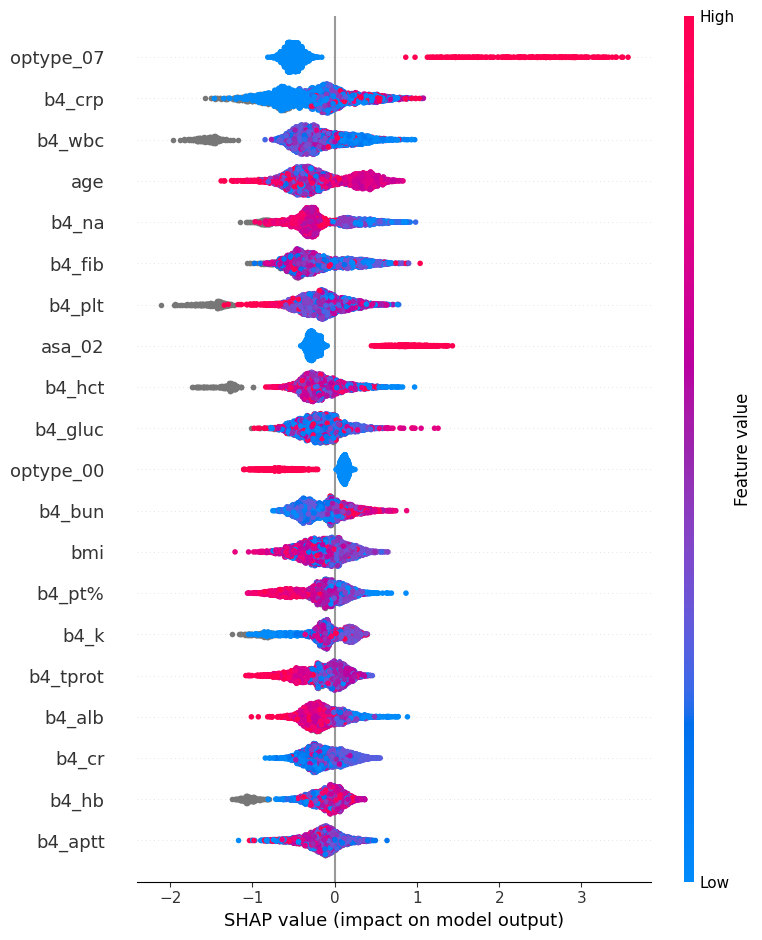

In [65]:
model_func.shap_summary_plot('xgbm_8.sav',X_train_75_complete)

# Try different Variations of input variable  

In [66]:
# Variation 8a
X_train_8a = X_train_75_complete[['optype_07']]
X_test_8a = X_test_75_complete[['optype_07']]

# Variation 8b
X_train_8b = X_train_75_complete[['optype_07', 'b4_crp']]
X_test_8b = X_test_75_complete[['optype_07', 'b4_crp']]

# Variation 8c
X_train_8c = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt']]
X_test_8c = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt']]

# Variation 8d
X_train_8d = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib']]
X_test_8d = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib']]

# Variation 8e
X_train_8e = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age']]
X_test_8e = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age']]

# Variation 8f
X_train_8f = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na']]
X_test_8f = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na']]

# Variation 8g
X_train_8g = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc']]
X_test_8g = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc']]

# Variation 8h
X_train_8h = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc']]
X_test_8h = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc']]

# Variation 8i
X_train_8i = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct']]
X_test_8i = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct']]

# Variation 8j
X_train_8j = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr']]
X_test_8j = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr']]

# Variation 8k
X_train_8k = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi']]
X_test_8k = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi']]

# Variation 8l
X_train_8l = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%']]
X_test_8l = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%']]

# Variation 8m
X_train_8m = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt']]
X_test_8m = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt']]

# Variation 8n
X_train_8n = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02']]
X_test_8n = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02']]

# Variation 8o
X_train_8o = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot']]
X_test_8o = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot']]

# Variation 8p
X_train_8p = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr']]
X_test_8p = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr']]

# Variation 8q
X_train_8q = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr', 'b4_bun']]
X_test_8q = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr', 'b4_bun']]

# Variation 8r
X_train_8r = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr', 'b4_bun', 'approach_01']]
X_test_8r = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr', 'b4_bun', 'approach_01']]

# Variation 8s
X_train_8s = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr', 'b4_bun', 'approach_01', 'b4_aptt']]
X_test_8s = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr', 'b4_bun', 'approach_01', 'b4_aptt']]

# Variation 8t
X_train_8t = X_train_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr', 'b4_bun', 'approach_01', 'b4_aptt', 'b4_alb']]
X_test_8t = X_test_75_complete[['optype_07', 'b4_crp', 'b4_plt', 'b4_fib', 'age', 'b4_na', 'b4_gluc', 'b4_wbc', 'b4_hct', 'b4_gfr', 'bmi', 'b4_pt%', 'b4_alt', 'asa_02', 'b4_tprot', 'b4_cr', 'b4_bun', 'approach_01', 'b4_aptt', 'b4_alb']]



def train_and_evaluate(X_train, y_train, X_test, y_test, variation_label):
    # Define the model
    gbm = XGBClassifier()
    
    # Define hyperparameters grid
    params = {'max_depth': [4, 6, 8, 10, 12],
              'max_leaves': [40, 60, 80, 100],
              'n_estimators': [50, 100, 200, 500],
              'learning_rate': [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001],
              'subsample': sp_uniform(loc=0.2, scale=0.8),
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
              'reg_alpha': [10, 0, 0.01, 0.03],
              'reg_lambda': [10, 0, 0.01, 0.03],
              'random_state': [42]}
    
    # Perform randomized search for best hyperparameters
    model = RandomizedSearchCV(gbm, params)
    model.fit(X_train, y_train)
    
    # Get the best hyperparameters
    best_params = model.best_params_
    
    # Print best parameters
    print("Best parameters found for Variation {}: {}".format(variation_label, best_params))
    
    # Initialize model with best hyperparameters
    model = XGBClassifier(**best_params)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    model_func.fit_model(model, 'XGB Classifier', 'xgbm_{}.sav'.format(variation_label), X_train, y_train)
    model_func.c_matrix('xgbm_{}.sav'.format(variation_label), 'Post-Operative Complications {}'.format(variation_label), y_test, X_test)
    model_func.plot_auc('xgbm_{}.sav'.format(variation_label), y_test, X_test)
    model_func.feature_importance('xgbm_{}.sav'.format(variation_label), X_train, 'Top Important Features{}'.format(variation_label))
    model_func.shap_summary_plot('xgbm_{}.sav'.format(variation_label), X_train)



## Variation 8a

Best parameters found for Variation 8a: {'colsample_bytree': 0.6553350731069243, 'gamma': 3.2, 'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 100, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.9560649997080468}
XGB Classifier
Start Time: 2024-05-05 00:18:34.320742
End Time: 2024-05-05 00:18:34.328119
Total time taken:0:00:00.007377
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       792
           1       0.00      0.00      0.00        53

    accuracy                           0.94       845
   macro avg       0.47      0.50      0.48       845
weighted avg       0.88      0.94      0.91       845



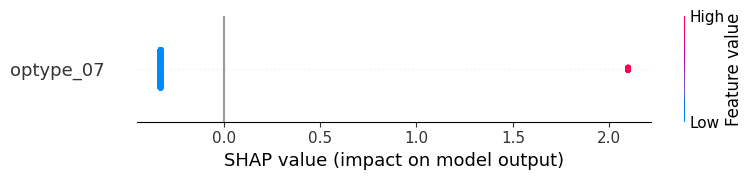

In [67]:
train_and_evaluate(X_train_8a, y_train, X_test_8a, y_test, "8a")

## Variation 8b

Best parameters found for Variation 8b: {'colsample_bytree': 0.6884464302391045, 'gamma': 6.4, 'learning_rate': 0.3, 'max_depth': 10, 'max_leaves': 100, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0, 'subsample': 0.586550181577001}
XGB Classifier
Start Time: 2024-05-05 00:18:36.158690
End Time: 2024-05-05 00:18:36.178695
Total time taken:0:00:00.020005
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       792
           1       0.75      0.06      0.11        53

    accuracy                           0.94       845
   macro avg       0.85      0.53      0.54       845
weighted avg       0.93      0.94      0.91       845



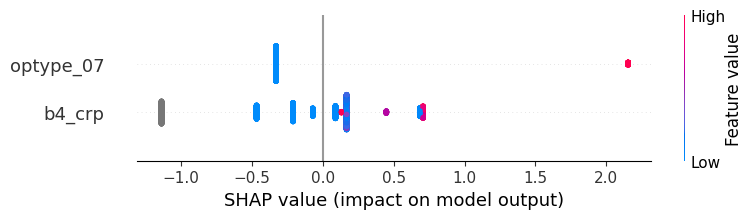

In [68]:
train_and_evaluate(X_train_8b, y_train, X_test_8b, y_test, "8b")

## Variation 8c

Best parameters found for Variation 8c: {'colsample_bytree': 0.8100650422589383, 'gamma': 12.8, 'learning_rate': 0.2, 'max_depth': 10, 'max_leaves': 40, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5062796688617561}
XGB Classifier
Start Time: 2024-05-05 00:18:39.626800
End Time: 2024-05-05 00:18:39.663942
Total time taken:0:00:00.037142
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.93      0.25      0.39        53

    accuracy                           0.95       845
   macro avg       0.94      0.62      0.68       845
weighted avg       0.95      0.95      0.94       845



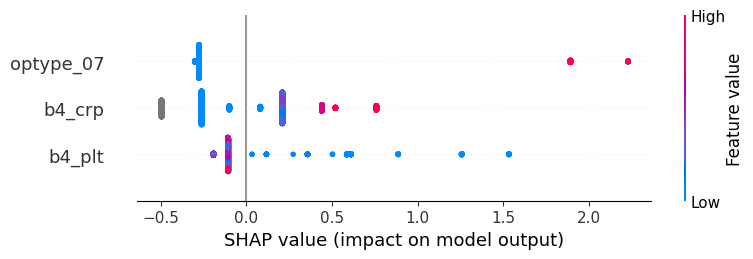

In [69]:
train_and_evaluate(X_train_8c, y_train, X_test_8c, y_test, "8c")

## Variation 8d

Best parameters found for Variation 8d: {'colsample_bytree': 0.7594091551041655, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'max_leaves': 100, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0.01, 'subsample': 0.6166716909218781}
XGB Classifier
Start Time: 2024-05-05 00:18:49.535899
End Time: 2024-05-05 00:18:49.594922
Total time taken:0:00:00.059023
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       792
           1       0.94      0.28      0.43        53

    accuracy                           0.95       845
   macro avg       0.95      0.64      0.71       845
weighted avg       0.95      0.95      0.94       845



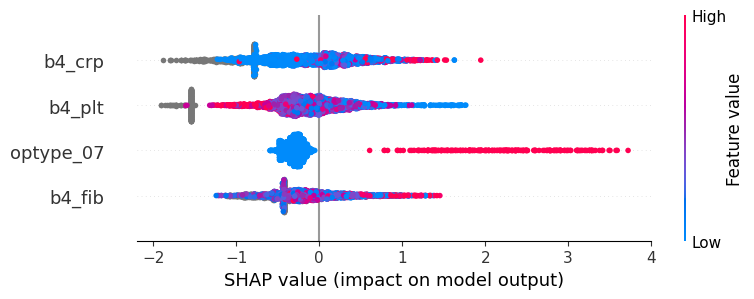

In [70]:
train_and_evaluate(X_train_8d, y_train, X_test_8d, y_test, "8d")

## Variation 8e

Best parameters found for Variation 8e: {'colsample_bytree': 0.6658820562206225, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 40, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 10, 'reg_lambda': 0.01, 'subsample': 0.4344028735516311}
XGB Classifier
Start Time: 2024-05-05 00:18:53.956332
End Time: 2024-05-05 00:18:54.016873
Total time taken:0:00:00.060541
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.88      0.26      0.41        53

    accuracy                           0.95       845
   macro avg       0.91      0.63      0.69       845
weighted avg       0.95      0.95      0.94       845



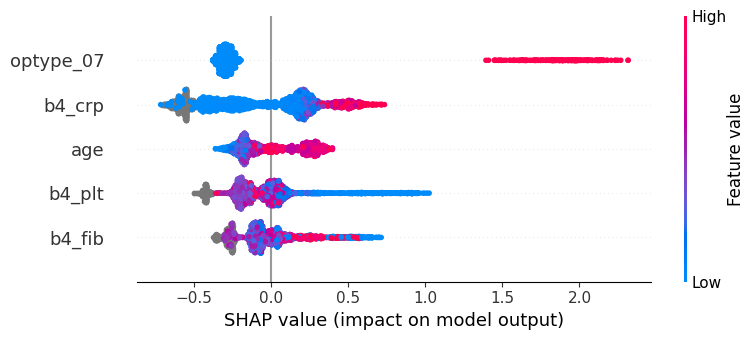

In [71]:
train_and_evaluate(X_train_8e, y_train, X_test_8e, y_test, "8e")

## Variation 8f

Best parameters found for Variation 8f: {'colsample_bytree': 0.4860222820317205, 'gamma': 3.2, 'learning_rate': 0.2, 'max_depth': 8, 'max_leaves': 80, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.03, 'subsample': 0.7162593781639883}
XGB Classifier
Start Time: 2024-05-05 00:18:57.434321
End Time: 2024-05-05 00:18:57.450396
Total time taken:0:00:00.016075
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.81      0.25      0.38        53

    accuracy                           0.95       845
   macro avg       0.88      0.62      0.68       845
weighted avg       0.94      0.95      0.94       845



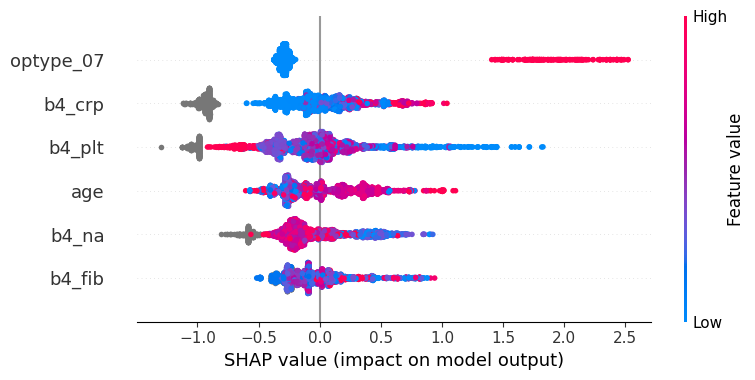

In [72]:
train_and_evaluate(X_train_8f, y_train, X_test_8f, y_test, "8f")

## Variation 8g

Best parameters found for Variation 8g: {'colsample_bytree': 0.8933050709812025, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 40, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.25475003137323227}
XGB Classifier
Start Time: 2024-05-05 00:19:01.054308
End Time: 2024-05-05 00:19:01.105485
Total time taken:0:00:00.051177
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.83      0.28      0.42        53

    accuracy                           0.95       845
   macro avg       0.89      0.64      0.70       845
weighted avg       0.95      0.95      0.94       845



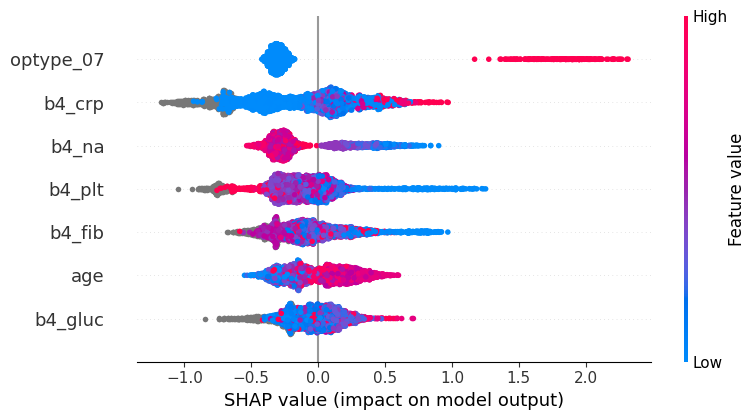

In [73]:
train_and_evaluate(X_train_8g, y_train, X_test_8g, y_test, "8g")

## Variation 8h

Best parameters found for Variation 8h: {'colsample_bytree': 0.7860689868802495, 'gamma': 0.8, 'learning_rate': 0.2, 'max_depth': 12, 'max_leaves': 80, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.03, 'subsample': 0.9649491003309896}
XGB Classifier
Start Time: 2024-05-05 00:19:06.920927
End Time: 2024-05-05 00:19:07.056802
Total time taken:0:00:00.135875
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.82      0.26      0.40        53

    accuracy                           0.95       845
   macro avg       0.89      0.63      0.69       845
weighted avg       0.94      0.95      0.94       845



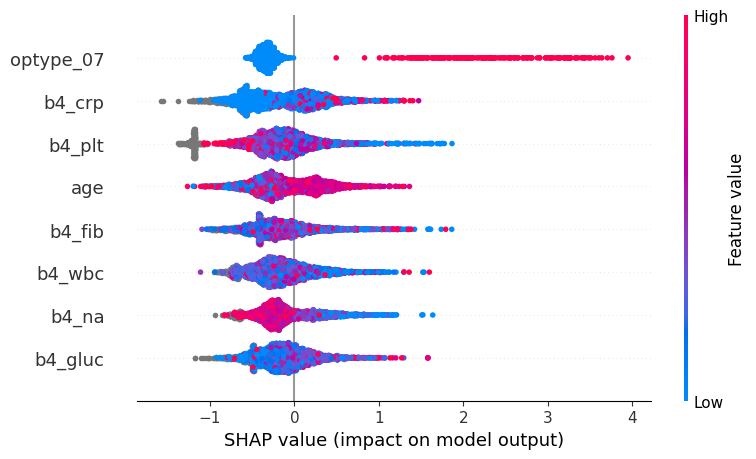

In [74]:

train_and_evaluate(X_train_8h, y_train, X_test_8h, y_test, "8h")

## Variation 8i

Best parameters found for Variation 8i: {'colsample_bytree': 0.8865865598144259, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 4, 'max_leaves': 100, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 10, 'subsample': 0.5138687546580625}
XGB Classifier
Start Time: 2024-05-05 00:19:11.785033
End Time: 2024-05-05 00:19:11.832482
Total time taken:0:00:00.047449
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.83      0.28      0.42        53

    accuracy                           0.95       845
   macro avg       0.89      0.64      0.70       845
weighted avg       0.95      0.95      0.94       845



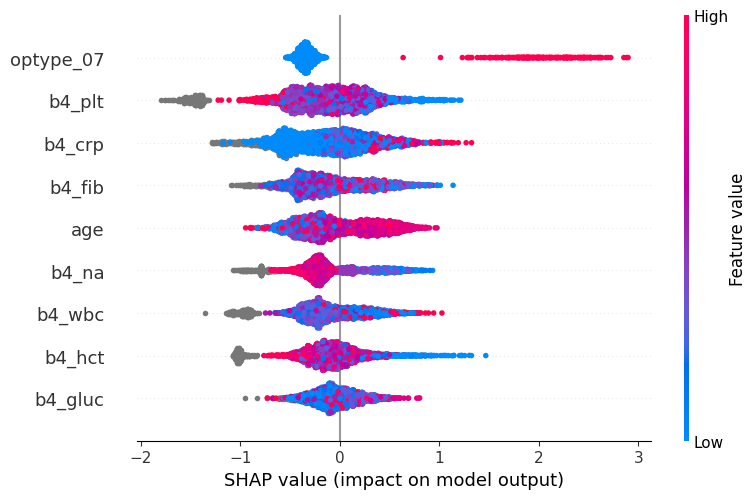

In [75]:
train_and_evaluate(X_train_8i, y_train, X_test_8i, y_test, "8i")

## Variation 8j

Best parameters found for Variation 8j: {'colsample_bytree': 0.8927547138757375, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'max_leaves': 60, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.03, 'subsample': 0.610046026642092}
XGB Classifier
Start Time: 2024-05-05 00:19:20.180807
End Time: 2024-05-05 00:19:20.851237
Total time taken:0:00:00.670430
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       792
           1       0.88      0.28      0.43        53

    accuracy                           0.95       845
   macro avg       0.92      0.64      0.70       845
weighted avg       0.95      0.95      0.94       845



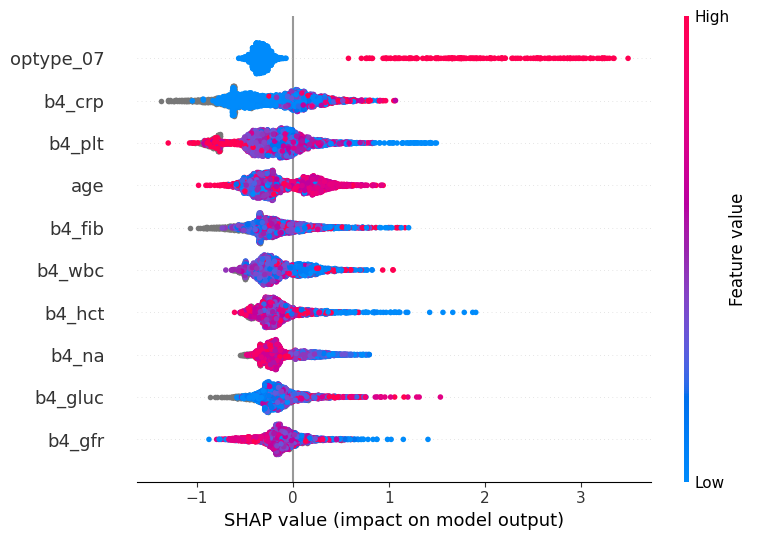

In [76]:
train_and_evaluate(X_train_8j, y_train, X_test_8j, y_test, "8j")

## Variation 8k

Best parameters found for Variation 8k: {'colsample_bytree': 0.6423157985425656, 'gamma': 6.4, 'learning_rate': 0.02, 'max_depth': 12, 'max_leaves': 80, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.03, 'subsample': 0.5517787463098209}
XGB Classifier
Start Time: 2024-05-05 00:19:29.093529
End Time: 2024-05-05 00:19:29.231234
Total time taken:0:00:00.137705
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.87      0.25      0.38        53

    accuracy                           0.95       845
   macro avg       0.91      0.62      0.68       845
weighted avg       0.95      0.95      0.94       845



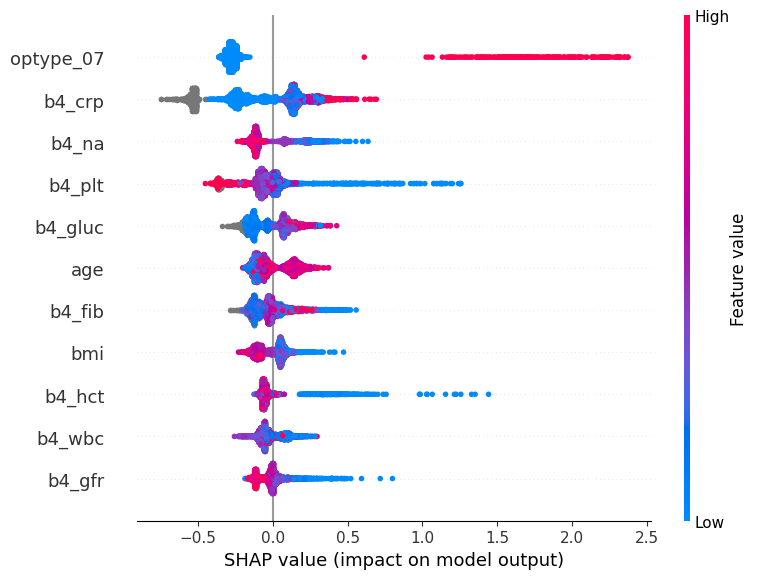

In [77]:

train_and_evaluate(X_train_8k, y_train, X_test_8k, y_test, "8k")

## Variation 8l

Best parameters found for Variation 8l: {'colsample_bytree': 0.47563694628602593, 'gamma': 1.6, 'learning_rate': 0.02, 'max_depth': 4, 'max_leaves': 40, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.03, 'subsample': 0.8664693398833418}
XGB Classifier
Start Time: 2024-05-05 00:19:35.688486
End Time: 2024-05-05 00:19:35.958017
Total time taken:0:00:00.269531
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       792
           1       0.89      0.32      0.47        53

    accuracy                           0.96       845
   macro avg       0.93      0.66      0.72       845
weighted avg       0.95      0.96      0.94       845



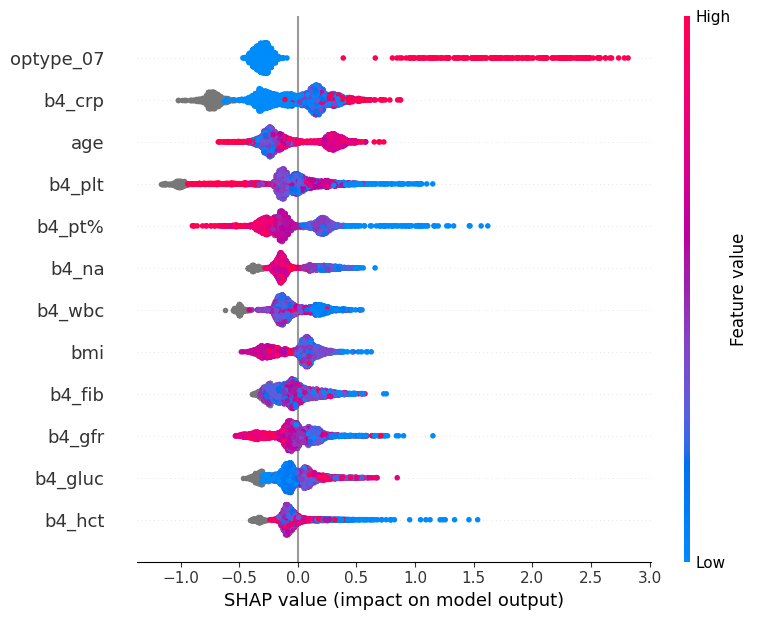

In [78]:
train_and_evaluate(X_train_8l, y_train, X_test_8l, y_test, "8l")

## Variation 8m

Best parameters found for Variation 8m: {'colsample_bytree': 0.8576518612353006, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 12, 'max_leaves': 80, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0, 'subsample': 0.4373027486349643}
XGB Classifier
Start Time: 2024-05-05 00:19:42.027607
End Time: 2024-05-05 00:19:42.157065
Total time taken:0:00:00.129458
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       792
           1       0.84      0.30      0.44        53

    accuracy                           0.95       845
   macro avg       0.90      0.65      0.71       845
weighted avg       0.95      0.95      0.94       845



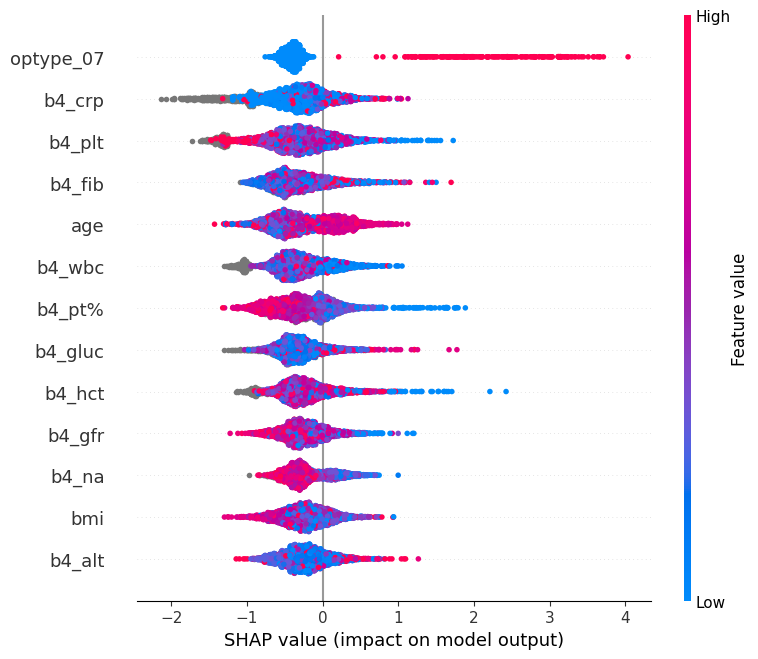

In [79]:
train_and_evaluate(X_train_8m, y_train, X_test_8m, y_test, "8m")


## Variation 8n

Best parameters found for Variation 8n: {'colsample_bytree': 0.6551270970657268, 'gamma': 1.6, 'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 40, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0, 'subsample': 0.9262118756911542}
XGB Classifier
Start Time: 2024-05-05 00:19:48.999778
End Time: 2024-05-05 00:19:49.076559
Total time taken:0:00:00.076781
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       792
           1       0.79      0.28      0.42        53

    accuracy                           0.95       845
   macro avg       0.87      0.64      0.70       845
weighted avg       0.94      0.95      0.94       845



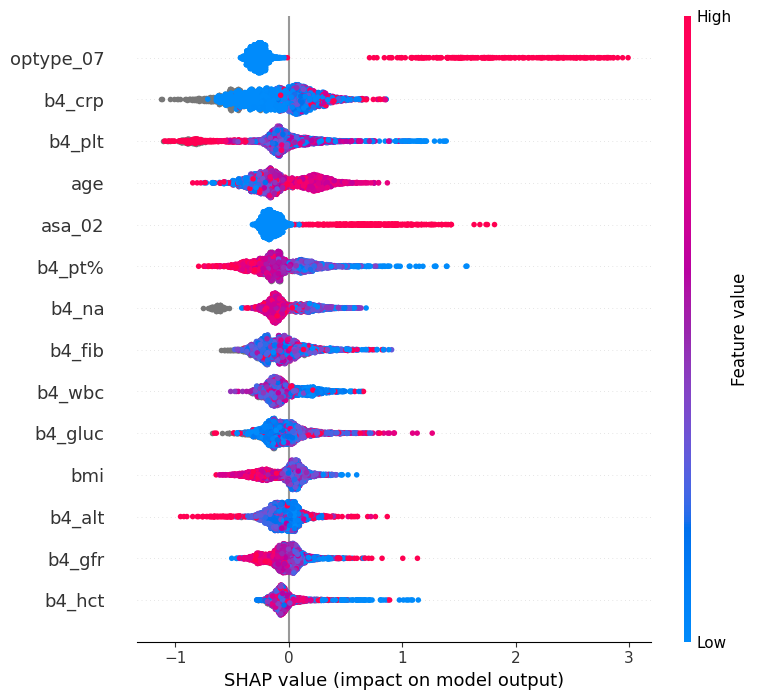

In [80]:
train_and_evaluate(X_train_8n, y_train, X_test_8n, y_test, "8n")

## Variation 8o

Best parameters found for Variation 8o: {'colsample_bytree': 0.9518938183072841, 'gamma': 3.2, 'learning_rate': 0.2, 'max_depth': 6, 'max_leaves': 80, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.03, 'subsample': 0.6266141986816205}
XGB Classifier
Start Time: 2024-05-05 00:19:53.391984
End Time: 2024-05-05 00:19:53.510889
Total time taken:0:00:00.118905
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.73      0.30      0.43        53

    accuracy                           0.95       845
   macro avg       0.84      0.65      0.70       845
weighted avg       0.94      0.95      0.94       845



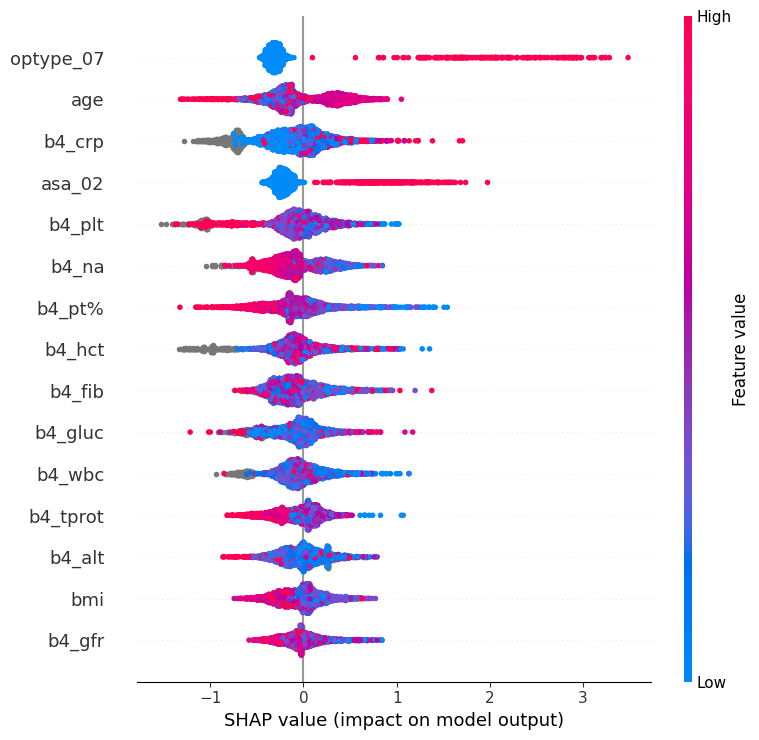

In [81]:

train_and_evaluate(X_train_8o, y_train, X_test_8o, y_test, "8o")

## Variation 8p

Best parameters found for Variation 8p: {'colsample_bytree': 0.6399666830756627, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'max_leaves': 80, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.9732363310897922}
XGB Classifier
Start Time: 2024-05-05 00:19:59.157915
End Time: 2024-05-05 00:19:59.198712
Total time taken:0:00:00.040797
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       792
           1       0.82      0.34      0.48        53

    accuracy                           0.95       845
   macro avg       0.89      0.67      0.73       845
weighted avg       0.95      0.95      0.94       845



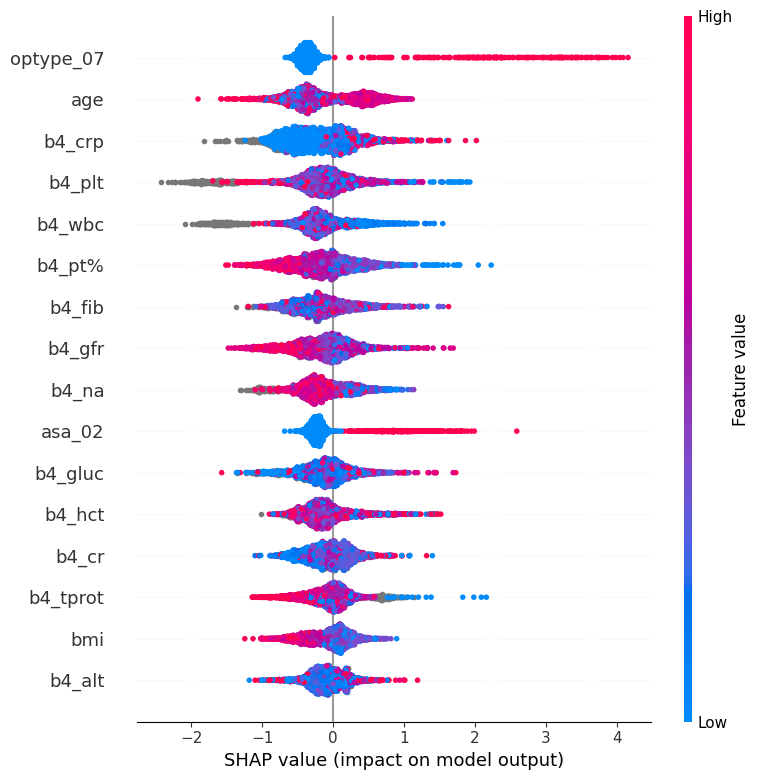

In [82]:
train_and_evaluate(X_train_8p, y_train, X_test_8p, y_test, "8p")

## Variation 8q

Best parameters found for Variation 8q: {'colsample_bytree': 0.6495648871159349, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 6, 'max_leaves': 80, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 10, 'subsample': 0.8091118167856732}
XGB Classifier
Start Time: 2024-05-05 00:20:08.276992
End Time: 2024-05-05 00:20:08.363268
Total time taken:0:00:00.086276
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       792
           1       0.88      0.28      0.43        53

    accuracy                           0.95       845
   macro avg       0.92      0.64      0.70       845
weighted avg       0.95      0.95      0.94       845



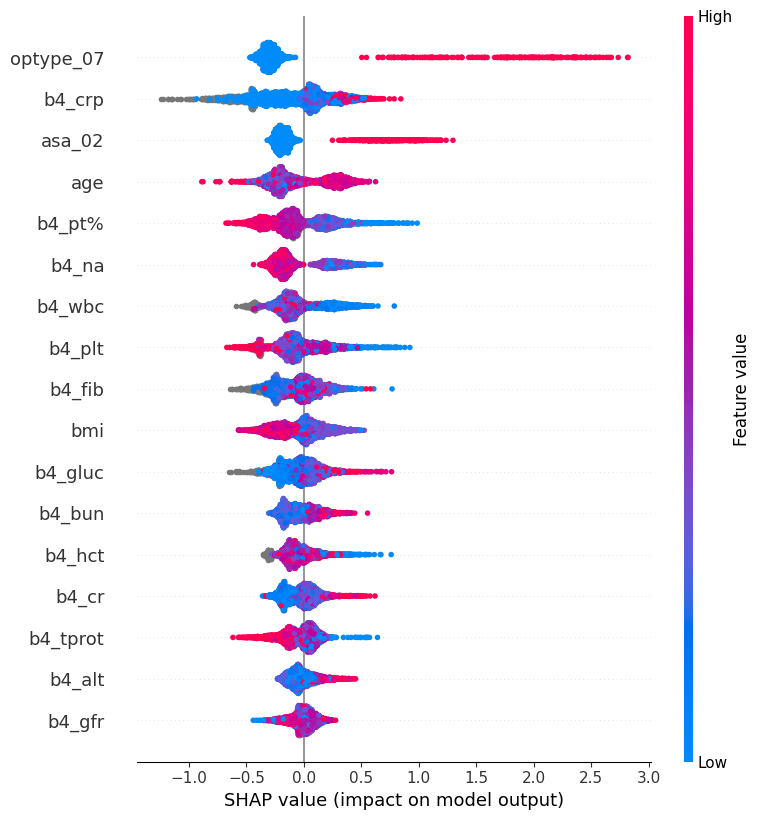

In [83]:
train_and_evaluate(X_train_8q, y_train, X_test_8q, y_test, "8q")

## Variation 8r

Best parameters found for Variation 8r: {'colsample_bytree': 0.6782202677337708, 'gamma': 3.2, 'learning_rate': 0.02, 'max_depth': 12, 'max_leaves': 100, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.03, 'subsample': 0.4217013196076329}
XGB Classifier
Start Time: 2024-05-05 00:20:18.829153
End Time: 2024-05-05 00:20:19.126310
Total time taken:0:00:00.297157
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       792
           1       0.84      0.30      0.44        53

    accuracy                           0.95       845
   macro avg       0.90      0.65      0.71       845
weighted avg       0.95      0.95      0.94       845



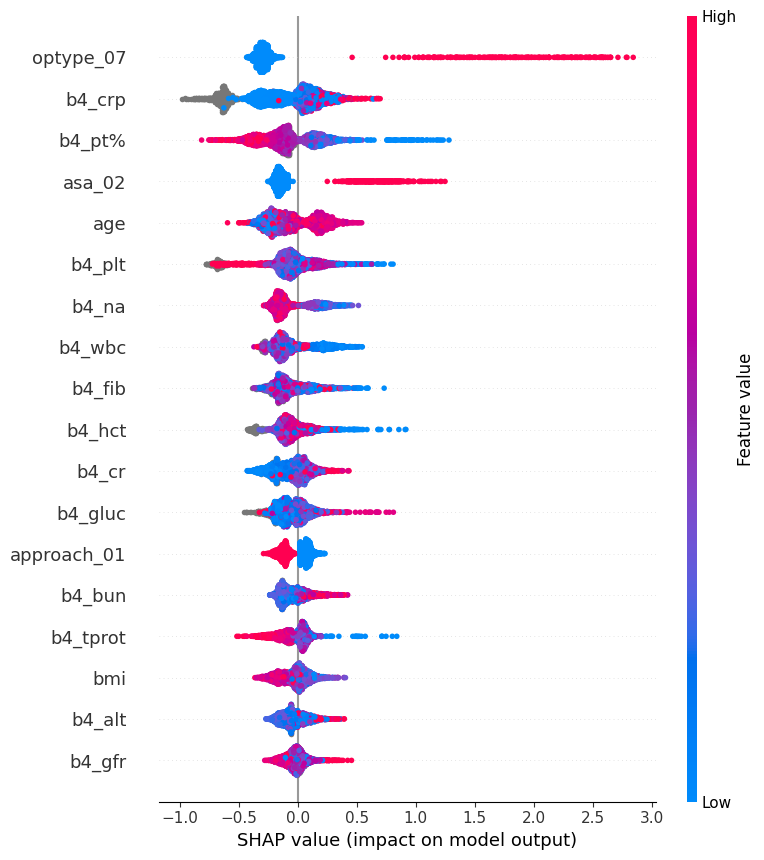

In [84]:
train_and_evaluate(X_train_8r, y_train, X_test_8r, y_test, "8r")

## Variation 8s

Best parameters found for Variation 8s: {'colsample_bytree': 0.49534507763081104, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 12, 'max_leaves': 60, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.9258980603409712}
XGB Classifier
Start Time: 2024-05-05 00:20:24.865065
End Time: 2024-05-05 00:20:25.023845
Total time taken:0:00:00.158780
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.80      0.30      0.44        53

    accuracy                           0.95       845
   macro avg       0.88      0.65      0.71       845
weighted avg       0.95      0.95      0.94       845



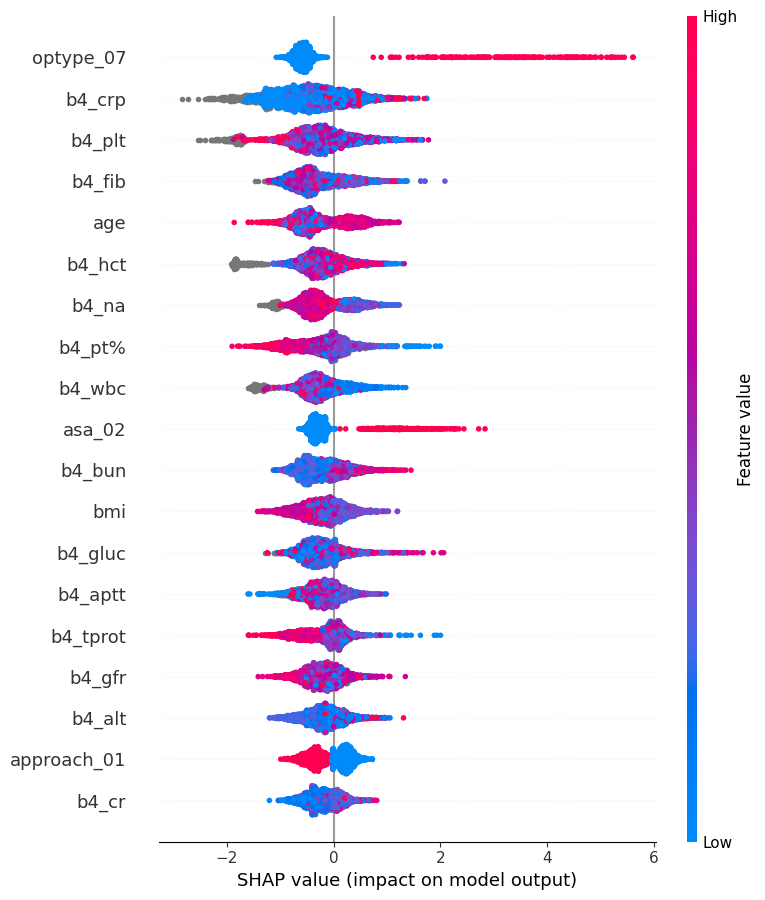

In [85]:
train_and_evaluate(X_train_8s, y_train, X_test_8s, y_test, "8s")

## Variation 8t

Best parameters found for Variation 8t: {'colsample_bytree': 0.7619343773049041, 'gamma': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'max_leaves': 60, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.7336323515379719}
XGB Classifier
Start Time: 2024-05-05 00:20:32.921852
End Time: 2024-05-05 00:20:33.565847
Total time taken:0:00:00.643995
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       792
           1       0.88      0.28      0.43        53

    accuracy                           0.95       845
   macro avg       0.92      0.64      0.70       845
weighted avg       0.95      0.95      0.94       845



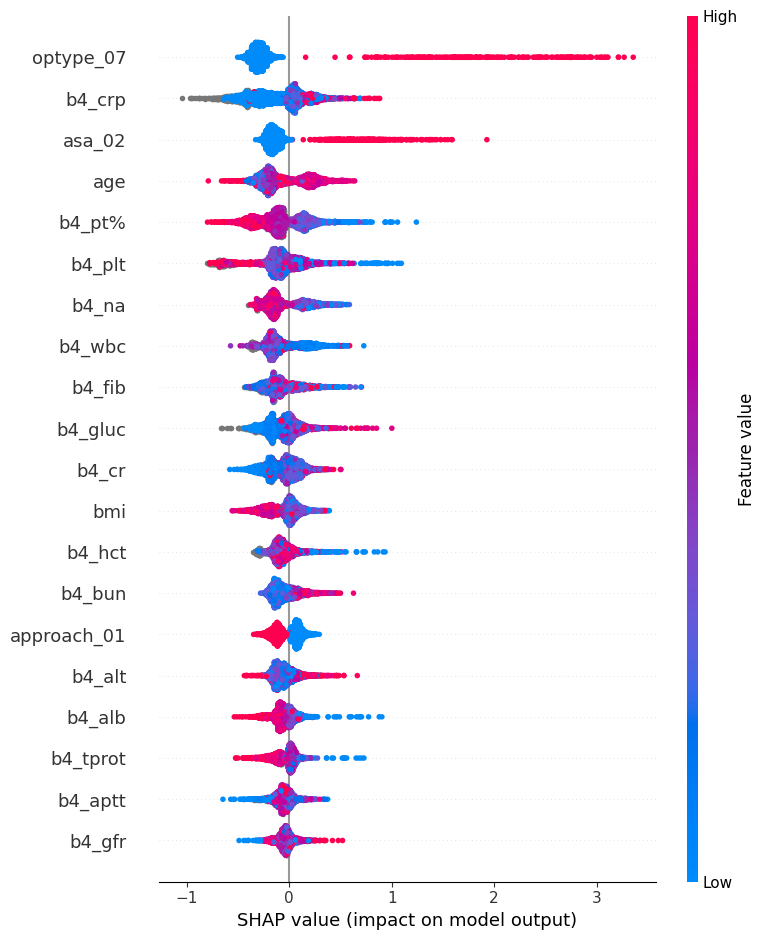

In [86]:
train_and_evaluate(X_train_8t, y_train, X_test_8t, y_test, "8t")